In [2]:
import tensorflow as tf
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
# from google.colab import files
# files.upload()
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from model_ckpt import DeepVIV,plot_solution
import pandas as pd

/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ritvik/anaconda3/envs/cfd_ml/lib/python3

In [3]:
# saver = tf.train.import_meta_graph('trained_models/model.ckpt.meta')

In [4]:
## Network shape
layers_uvp = [3] + 10*[3*32] + [3]
layers_eta  = [1] + 10*[1*32] + [1]

def create_tensors(data):
    
    t_star = data['t'] # T x 1
    eta_star = data['eta'] # T x 1
    
    T = t_star.shape[0]
        
    X_star = data['x']
    Y_star = data['y']        
    U_star = data['u']
    V_star = data['v']
    P_star = data['p']

    t = t_star.to_numpy()
    eta = eta_star.to_numpy()
    
    # T = t_star.shape[0]
        
    x = X_star.to_numpy()
    y = Y_star.to_numpy()        
    u = U_star.to_numpy()
    v = V_star.to_numpy()
    p = P_star.to_numpy()
    
    t = t.reshape((t.shape[0],1))
    x = x.reshape((x.shape[0],1))
    y = y.reshape((y.shape[0],1))
    u = u.reshape((u.shape[0],1))
    v = v.reshape((v.shape[0],1))
    p = p.reshape((p.shape[0],1))
    eta = eta.reshape((eta.shape[0],1))
    
    return t,x,y,u,v,p,eta

In [5]:
time_1 = time.time()
data = pd.read_csv("final_translated_data.csv")
print("[INFO] Time taken = "+str(time.time()-time_1)+" seconds.")
data

[INFO] Time taken = 5.147411584854126 seconds.


,t,x,y,u,v,p,eta,velocity_y,acceleration_y
0,1.00,0.568927,-0.046606,0.087128,-0.001323,4.622246,-0.027765,-0.443435,-7.863445
1,1.00,1.290390,-0.023081,1.366555,0.085248,0.153395,-0.027765,-0.443435,-7.863445
2,1.00,1.290373,0.063638,1.058568,0.287478,-0.125707,-0.027765,-0.443435,-7.863445
3,1.00,1.290382,0.034726,1.136679,0.242483,-0.021684,-0.027765,-0.443435,-7.863445
4,1.00,1.319255,0.034768,1.071537,0.162342,-0.025877,-0.027765,-0.443435,-7.863445
...,...,...,...,...,...,...,...,...,...
3886677,3.01,1.261377,0.303673,0.734870,0.684885,0.380411,-0.099309,-0.657429,4.613411
3886678,3.01,1.261397,0.272308,0.727909,0.732213,0.381629,-0.099309,-0.657429,4.613411
3886679,3.01,1.232511,0.270750,0.674244,0.725419,0.383377,-0.099309,-0.657429,4.613411
3886680,3.01,1.290281,0.274201,0.774205,0.726929,0.377228,-0.099309,-0.657429,4.613411


In [6]:
t,x,y,u,v,p,eta = create_tensors(data)
t.shape,x.shape,y.shape,u.shape,v.shape,p.shape,eta.shape

((3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1),
 (3886682, 1))

In [7]:
N_train = 3700000
idx = np.random.choice(t.shape[0], N_train, replace=False)
t_train = t[idx]
x_train = x[idx]
y_train = y[idx]
u_train = u[idx]
v_train = v[idx]
p_train = p[idx]
eta_train = eta[idx]
t_train.shape,x_train.shape,y_train.shape,u_train.shape,v_train.shape,p_train.shape,eta_train.shape

((3700000, 1),
 (3700000, 1),
 (3700000, 1),
 (3700000, 1),
 (3700000, 1),
 (3700000, 1),
 (3700000, 1))

In [8]:
model = DeepVIV(t_train, x_train, y_train, u_train, v_train, eta_train, layers_uvp, layers_eta, Re=1000)

In [8]:
sess = tf.Session()
saver = tf.train.import_meta_graph('trained_models/model_foil.meta')
# saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('trained_models'))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from trained_models/model_foil


In [10]:
N_test = 1000
idx_2 = np.random.choice(t.shape[0], N_test, replace=False)
t_test = t[idx_2]
x_test = x[idx_2]
y_test = y[idx_2]
u_test = u[idx_2]
v_test = v[idx_2]
p_test = p[idx_2]
eta_test = eta[idx_2]
t_test.shape,x_test.shape,y_test.shape,u_test.shape,v_test.shape,p_test.shape,eta_test.shape

((1000, 1), (1000, 1), (1000, 1), (1000, 1), (1000, 1), (1000, 1), (1000, 1))

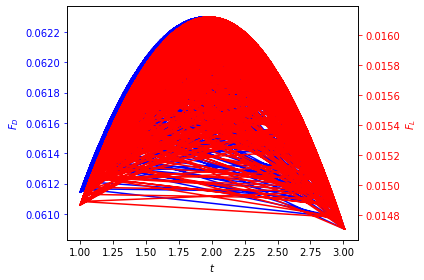

In [11]:
F_D, F_L = model.predict_drag_lift(t_test)
    
fig, ax1 = plt.subplots()
ax1.plot(t_test, F_D, 'b')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$F_D$', color='b')
ax1.tick_params('y', colors='b')
    
ax2 = ax1.twinx()
ax2.plot(t_test, F_L, 'r')
ax2.set_ylabel('$F_L$', color='r')
ax2.tick_params('y', colors='r')
    
fig.tight_layout()
# path = '/content/drive/My Drive/Colab Notebooks/DeepVIV/'
savefig('Figures/VIV_data_on_velocities_lift_drag', crop = False)

Error u: 1.003602e+00
Error v: 1.014729e+00
Error p: nan
Error eta: 1.126109e+00


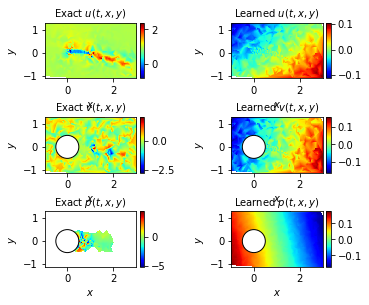

In [12]:
    # Prediction
    u_pred, v_pred, p_pred, eta_pred = model.predict(t_test, x_test, y_test)
    
    # Error
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    error_v = np.linalg.norm(v_test-v_pred,2)/np.linalg.norm(v_test,2)
    error_p = np.linalg.norm(p_test-p_pred,2)/np.linalg.norm(p_test,2)
    error_eta = np.linalg.norm(eta_test-eta_pred,2)/np.linalg.norm(eta_test,2)

    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))
    print('Error p: %e' % (error_p))
    print('Error eta: %e' % (error_eta))
        
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################
    
    circle11 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle12 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle21 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle22 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle31 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle32 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle41 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    circle42 = plt.Circle((0, 0), 0.5, facecolor='w', edgecolor='k')
    
    fig, ax = newfig(1.0, 1.6)
    ax.axis('off')

    gs = gridspec.GridSpec(4, 2)
    gs.update(top=0.95, bottom=0.07, left=0.1, right=0.9, wspace=0.5, hspace=0.7)
        
    ########      Exact u(t,x,y)     ###########     
    ax = plt.subplot(gs[0:1, 0])
    h = plot_solution(x_test,y_test,u_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle21)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $u(t,x,y)$', fontsize = 10)
    
    ########     Learned u(t,x,y)     ###########
    ax = plt.subplot(gs[0:1, 1])
    h = plot_solution(x_test,y_test,u_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
#     ax.add_artist(circle22)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $u(t,x,y)$', fontsize = 10)
    
    ########      Exact v(t,x,y)     ###########     
    ax = plt.subplot(gs[1:2, 0])
    h = plot_solution(x_test,y_test,v_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.add_artist(circle31)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $v(t,x,y)$', fontsize = 10)
    
    ########     Learned v(t,x,y)     ###########
    ax = plt.subplot(gs[1:2, 1])
    h = plot_solution(x_test,y_test,v_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.add_artist(circle32)
    ax.axis('equal')
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $v(t,x,y)$', fontsize = 10)
    
    ########      Exact p(t,x,y)     ###########     
    ax = plt.subplot(gs[2:3, 0])
    h = plot_solution(x_test,y_test,p_test,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.add_artist(circle41)
    ax.axis('equal')    
    
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Exact $p(t,x,y)$', fontsize = 10)
    
    ########     Learned p(t,x,y)     ###########
    ax = plt.subplot(gs[2:3, 1])
    h = plot_solution(x_test,y_test,p_pred,ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.add_artist(circle42)
    ax.axis('equal')
        
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('Learned $p(t,x,y)$', fontsize = 10)
    
    savefig('Figures/VIV_data_on_velocities', crop = False)
    